In [ ]:
from google.colab import auth
auth.authenticate_user()

import pandas as pd
import gspread
from google.auth import default
import numpy as np

fake_news_dataset = 'https://docs.google.com/spreadsheets/d/1CO92-yWAzS5jBo2j5YwgJum4uw0atMOv4g20HxI25Uc/edit?usp=sharing'
non_fake_news_dataset = 'https://docs.google.com/spreadsheets/d/1jNuBXpuQpPBe8RKS7xrZn8_QXg4TpF_SuzlRKoW14Xo/edit#gid=752465616'

creds, _ = default()

gc = gspread.authorize(creds)

# read data and put it in a dataframe
gsheets_fake = gc.open_by_url(fake_news_dataset)
sheets = gsheets_fake.worksheet('Fake.csv').get_all_values()
fake_df = pd.DataFrame(sheets[1:], columns=sheets[0])

gsheets_non_fake = gc.open_by_url(non_fake_news_dataset)
sheets = gsheets_non_fake.worksheet('True.csv').get_all_values()
non_fake_df = pd.DataFrame(sheets[1:], columns=sheets[0])

In [ ]:
import re
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib as mpl
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
stopwords_en = stopwords.words('english')
stemmerSnowball = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

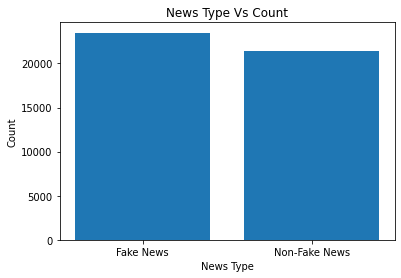

In [ ]:
plt.bar(['Fake News','Non-Fake News'], [fake_df.shape[0],non_fake_df.shape[0]])
plt.title('News Type Vs Count')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

In [ ]:
def text_preprocessing(text):

    text = text.lower()
    #Remove <br/> tags
    text = re.sub(r"\<.*\/\>",'',text)

    #Remove words containing numbers/digits
    text = re.sub(r'\w*\d\w*',"",text)

    #Expanding contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    try:
      #Remove the data source. US ( Reuters ) - <text>
      split_text = text.split(") -")
      for _ in split_text[1:]:
        text = text + ' ' + _
    except:
      pass 
    #removing certain sized words
    text=' '.join([i for i in text.split() if len(i)>2])

    #Remove HTML tags
    remove_html_tags = [re.sub(r"\<.*\>",'',word) for word in text.split(" ") ]

    #Remove words inside brackets
    remove_bracket_words = [re.sub(r"\(.*\)",'',word) for word in remove_html_tags ]

    #Words
    words = [re.sub(r'[^\w\s]','',word) for word in text.split(' ')]

    #Removing StopWords
    without_stop_words =  [re.sub(r'[^\w+]','',word) for word in words if word not in stopwords_en]

    #Lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in without_stop_words]
    
    #Tokenization
    tokenized = [" ".join(tokenizer.tokenize(word)) for word in lemmatized]

    return re.sub(' +', ' ',str(" ".join(tokenized)))

In [ ]:
fake_df['pre_processed_title'] = fake_df['title'].progress_apply(lambda row:text_preprocessing(row))
fake_df['pre_processed_text'] = fake_df['text'].progress_apply(lambda row:text_preprocessing(row))

non_fake_df['pre_processed_title'] = non_fake_df['title'].progress_apply(lambda row:text_preprocessing(row))
non_fake_df['pre_processed_text'] = non_fake_df['text'].progress_apply(lambda row:text_preprocessing(row))

  0%|          | 0/23481 [00:00<?, ?it/s]

  0%|          | 0/23481 [00:00<?, ?it/s]

  0%|          | 0/21417 [00:00<?, ?it/s]

  0%|          | 0/21417 [00:00<?, ?it/s]

In [ ]:
fake_df['stop_words_len'] = fake_df['text'].apply(lambda x: len([_ for _ in x.split() if _ in stopwords_en]))
non_fake_df['stop_words_len'] = non_fake_df['text'].apply(lambda x: len([_ for _ in x.split() if _ in stopwords_en]))

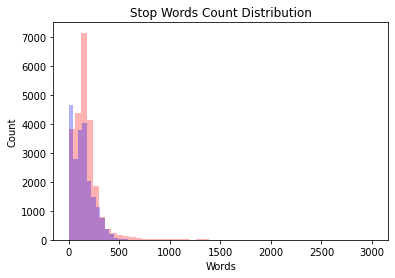

In [ ]:
ax = fake_df['stop_words_len'].plot(kind='hist',bins=50,title='Stop Words Count Distribution',color='r', alpha=0.3)
ax = non_fake_df['stop_words_len'].plot(kind='hist',bins=50,title='Stop Words Count Distribution',color='b', alpha=0.3)

ax.set(xlabel='Words',ylabel='Count')
plt.show()

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

fake_df['word_count_title'] = fake_df['pre_processed_title'].apply(lambda x: len(word_tokenize(x)))
fake_df['word_count_text'] = fake_df['pre_processed_text'].apply(lambda x: len(word_tokenize(x)))
non_fake_df['word_count_title'] = non_fake_df['pre_processed_title'].apply(lambda x: len(word_tokenize(x)))
non_fake_df['word_count_text'] = non_fake_df['pre_processed_text'].apply(lambda x: len(word_tokenize(x)))

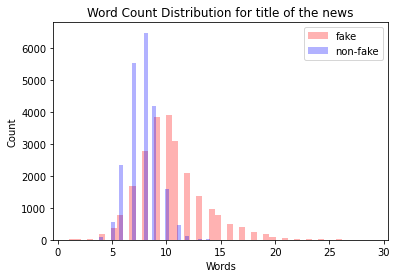

In [ ]:
ax = fake_df['word_count_title'].plot(kind='hist',bins=50,title='Word Count Distribution for title of the news',color='r', alpha=0.3)
ax = non_fake_df['word_count_title'].plot(kind='hist',bins=50,title='Word Count Distribution for title of the news',color='b', alpha=0.3)

ax.set(xlabel='Words',ylabel='Count')
ax.legend(labels=['fake','non-fake'])
plt.show()

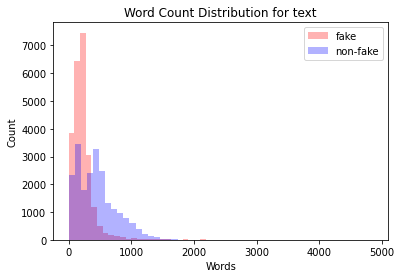

In [ ]:
ax = fake_df['word_count_text'].plot(kind='hist',bins=50,title='Word Count Distribution for text',color='r', alpha=0.3)
ax = non_fake_df['word_count_text'].plot(kind='hist',bins=50,title='Word Count Distribution for text',color='b', alpha=0.3)

ax.set(xlabel='Words',ylabel='Count')
ax.legend(labels=['fake','non-fake'])
plt.show()

In [ ]:
fake_df['sentence_count_text'] = fake_df['text'].apply(lambda x: len(sent_tokenize(x)))
non_fake_df['sentence_count_text'] = non_fake_df['text'].apply(lambda x: len(sent_tokenize(x)))

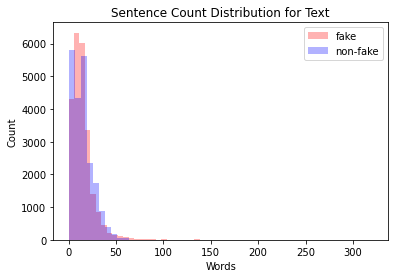

In [ ]:
ax = fake_df['sentence_count_text'].plot(kind='hist',bins=50,title='Sentence Count Distribution for Text',color='r', alpha=0.3)
ax = non_fake_df['sentence_count_text'].plot(kind='hist',bins=50,title='Sentence Count Distribution for Text',color='b', alpha=0.3)

ax.set(xlabel='Words',ylabel='Count')
ax.legend(labels=['fake','non-fake'])

plt.show()

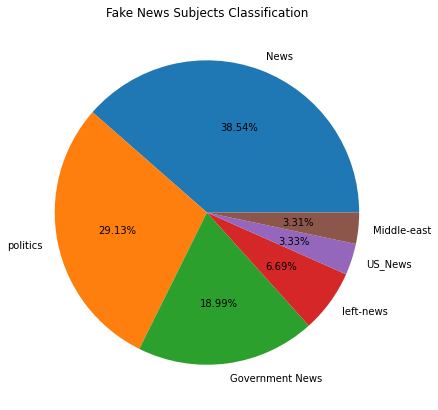

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.pie(fake_df['subject'].value_counts(), labels = fake_df['subject'].unique(),autopct = "%0.2f%%")
plt.title('Fake News Subjects Classification')
plt.show()

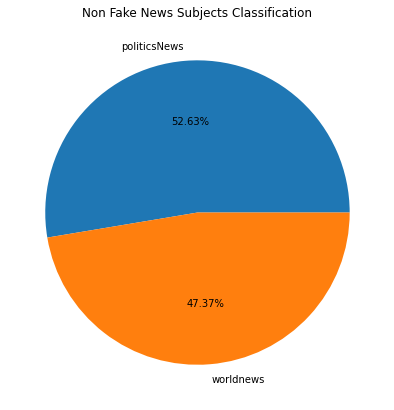

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.pie(non_fake_df['subject'].value_counts(), labels = non_fake_df['subject'].unique(),autopct = "%0.2f%%")
plt.title('Non Fake News Subjects Classification')
plt.show()

In [ ]:
blob = TextBlob(str(non_fake_df['text']))
non_fake_df_ = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
non_fake_df_ = non_fake_df_.pos.value_counts()[:20]

In [ ]:
blob = TextBlob(str(fake_df['text']))
fake_df_ = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
fake_df_ = fake_df_.pos.value_counts()[:20]

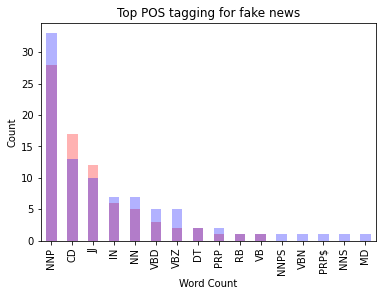

In [ ]:
ax = non_fake_df_.plot(kind='bar',xlabel='Parts Of Speech',ylabel='Counts', title='Top POS tagging for non-fake news',color='r', alpha=0.3)
ax = fake_df_.plot(kind='bar',xlabel='Parts Of Speech',ylabel='Counts', title='Top POS tagging for fake news',color='b', alpha=0.3)
ax.set(xlabel='Word Count',ylabel='Count')
plt.show()

In [ ]:
non_fake_words_ = ""
fake_words_ = ""
for index, row in non_fake_df.iterrows():
    for word in row['pre_processed_text']:
        non_fake_words_ += " ".join(word)

for index, row in fake_df.iterrows():
    for word in row['pre_processed_text']:
        fake_words_ += " ".join(word)

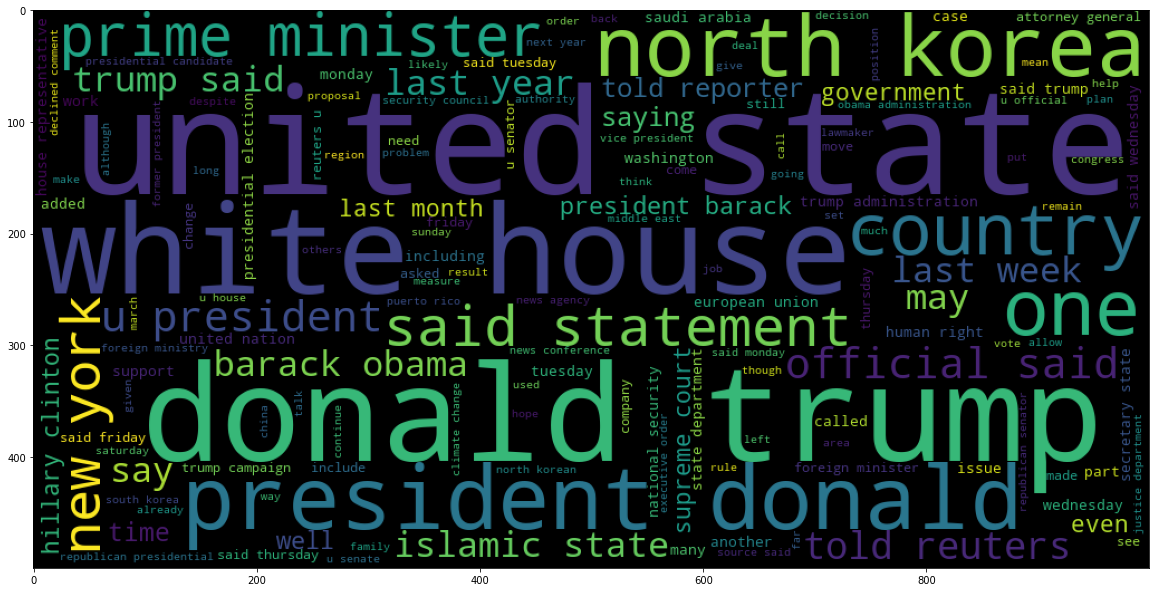

In [ ]:
mpl.rcParams['figure.figsize'] = 20,15
wordcloud = WordCloud(width = 1000, height = 500,background_color ='black',min_font_size = 10).generate(non_fake_words_)
plt.imshow(wordcloud)

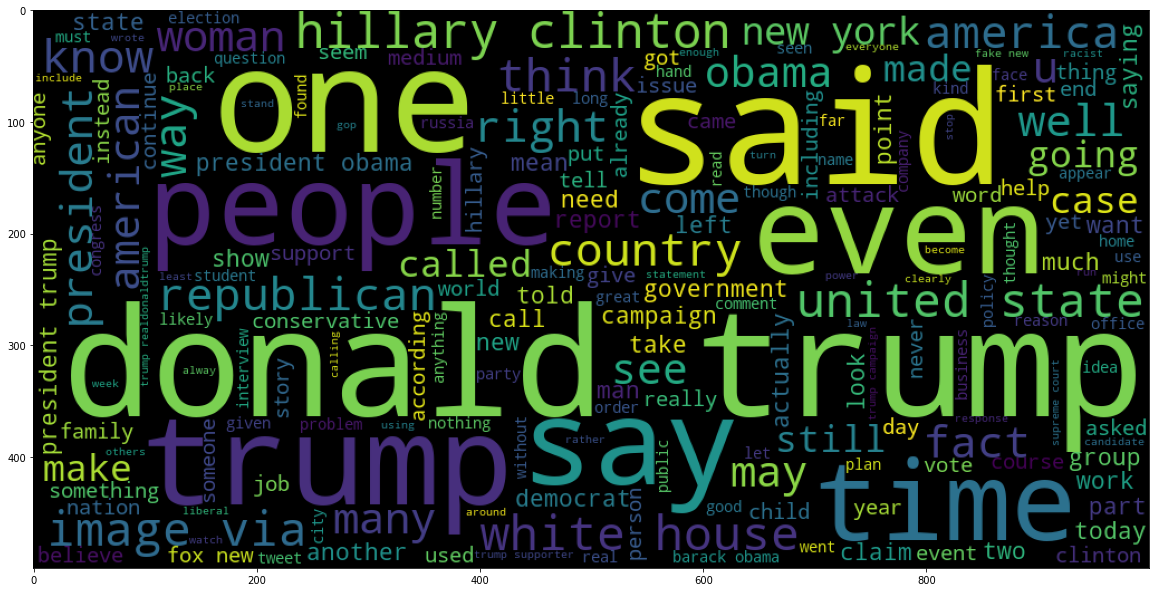

In [ ]:
mpl.rcParams['figure.figsize'] = 20,15
wordcloud = WordCloud(width = 1000, height = 500,background_color ='black',min_font_size = 10).generate(fake_words_)
plt.imshow(wordcloud)

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
most_common_uni = get_top_text_ngrams(fake_df.pre_processed_text,20,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in fake news', orientation='h', width=700, height=700,color='Common_words')
fig.show()

Fake News are based on various screen / video captures, images and such. Maybe New York is the center for fake news. Fake News ask users to subscribe to them.

In [ ]:
most_common_bi = get_top_text_ngrams(non_fake_df.pre_processed_text,20,3)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in non fake news', orientation='h', width=700, height=700,color='Common_words')
fig.show()

The non-fake news may have either their source of information from sources such as the White House, Reuters, different presidents such as Vladimir Putin, Donald Trumph, Barak Obama.